# Crack Detection

Crack detection has vital importance for structural health monitoring and inspection. We would like to train a network to detect Cracks, we will denote the images that contain cracks as positive and images with no cracks as negative.

In [4]:
#import libraries
import os
import glob
import pandas
import torch 
import matplotlib.pylab as plt
import numpy as np
import torch.nn as nn
import torchvision.models as models
import zipfile
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)

Function to show images

In [5]:
#for displaying images
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

### Load Images

In [ ]:
#Unzip file containing images
zip_file_path = 'concrete_crack_images_for_classification.zip'
to_directory = '.\data'

os.makedirs(to_directory, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(to_directory)

print(f'Extracted all files to {to_directory}')

In [6]:
#sort positive images
directory = '.\data'
positive="Positive"
positive_file_path=os.path.join(directory,positive)

positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
positive_files.sort()
positive_files[0:3]

['.\\data\\Positive\\00001.jpg',
 '.\\data\\Positive\\00002.jpg',
 '.\\data\\Positive\\00003.jpg']

In [7]:
#sort negative images
directory = '.\data'
negative="Negative"
negative_file_path=os.path.join(directory,negative)

negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()
negative_files[0:3]

['.\\data\\Negative\\00001.jpg',
 '.\\data\\Negative\\00002.jpg',
 '.\\data\\Negative\\00003.jpg']

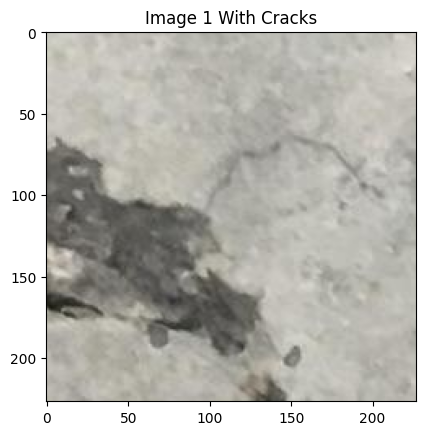

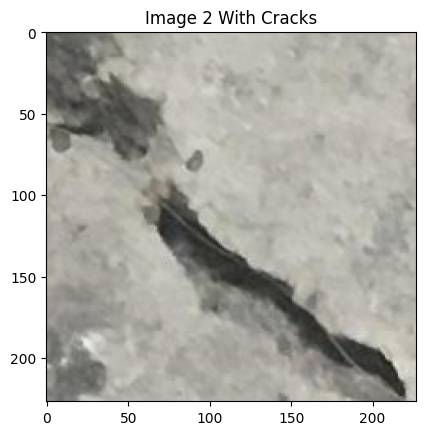

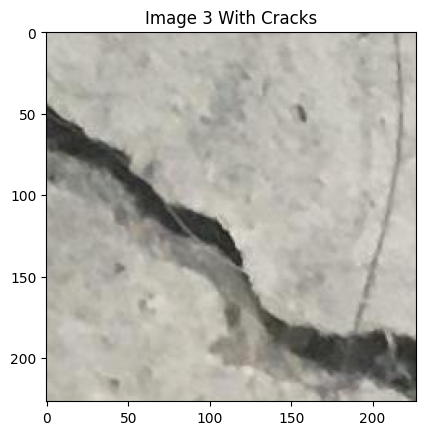

In [8]:
#Show some images with cracks
i = 0
for img in positive_files[567:570]:
    i += 1
    image2 = Image.open(img)
    plt.imshow(image2)
    plt.title(f'Image {i} With Cracks')
    plt.show()

In [9]:
number_of_samples = len(positive_files) + len(negative_files)
number_of_samples

40000

In [10]:
#For loading dataset

class Dataset(Dataset):
    
    def __init__(self,transform=None,train=True):
        directory="./data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples = len(positive_files) + len(negative_files)
        
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is going to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        num_train_samples = 30000
        
        if train:
            self.all_files = self.all_files[:num_train_samples]
            self.Y = self.Y[:num_train_samples]
        else:
            self.all_files = self.all_files[num_train_samples:]
            self.Y = self.Y[num_train_samples:]

        # Set the length of the dataset
        self.len = len(self.all_files)
       
    # Get the length
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [12]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [13]:
size_of_image=3*227*227
size_of_image

154587

### Linear Model
Train a Linear model to serve as baseline for accuracy

In [41]:
torch.manual_seed(0)

In [42]:
#model class
class Linear(nn.Module):
    def __init__(self,in_size,out_size):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_size, out_size)
        
    def forward(self, x):
        out = self.linear(x)
        return out

In [43]:
model = Linear(size_of_image, 2)

In [44]:
optimizer = torch.optim.SGD(params = model.parameters(),lr=0.1, momentum=0.1)
criterion = nn.CrossEntropyLoss()


In [45]:
#data loader
train_loader = DataLoader(dataset = dataset_train, batch_size = 500)
val_loader = DataLoader(dataset = dataset_val, batch_size = 500)

In [46]:
#train model

LOSS=[]
accuracy = []
epochs=2
   
for epoch in range(epochs):
    for x,y in train_loader:
        yhat=model(x.view(-1,size_of_image))
        loss=criterion(yhat,y)
        LOSS.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    correct = 0
    
    for x,y in val_loader:
        y_pred = model(x.view(-1,size_of_image))
        _, pred = torch.max(y_pred, 1)
        correct += (pred == y).sum().item()
            
    acc = correct / len(val_loader.dataset)
    accuracy.append(acc)

In [47]:
accuracy

[0.7252, 0.4701]

### Transfer Learning using Resnet18

In [25]:
#set transformer
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform =transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),transforms.Normalize(mean, std)])

In [26]:
#split data
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [16]:
#import model
model = models.resnet18(pretrained=True)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
#set model parameters
for param in model.parameters():
    param.requires_grad=False

In [18]:
#change output layer
model.fc = nn.Linear(512,2)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [20]:
#data loader
train_loader = DataLoader(dataset = dataset_train, batch_size = 200)
val_loader = DataLoader(dataset = dataset_val, batch_size = 200)

In [21]:
#train model

n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(dataset_val)
N_train=len(dataset_train)

Loss=0
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train()
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in val_loader:
        model.eval()
        y_pred = model(x_test)
        _, pred = torch.max(y_pred, 1)
        correct +=(pred==y_test).sum().item()
        
    accuracy=correct/N_test


In [22]:
#check accuracy
accuracy

0.9889

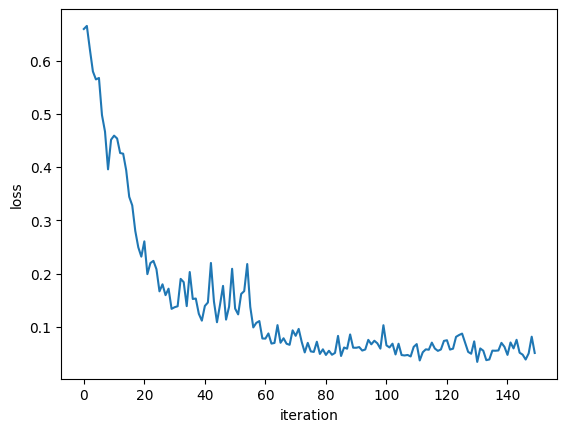

In [23]:
#plot loss
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [25]:
torch.save(model, 'model.pth')

In [14]:
model = torch.load('model.pth')

C:\Users\USER\AppData\Local\Temp\ipykernel_6400\1436957623.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')


#### Show some random sample predictions

In [41]:

choice = list(np.random.choice(range(0,1000), size =5))
predictions = {}
for idx in choice:
    model.eval()
    x = dataset_val[idx][0].unsqueeze(0)
    y_pred = model(x)
    _, pred = torch.max(y_pred, 1)
    if pred == 1:
        y = 'Positive'
    else:
        y = 'Negative'
    predictions[idx] = y
    

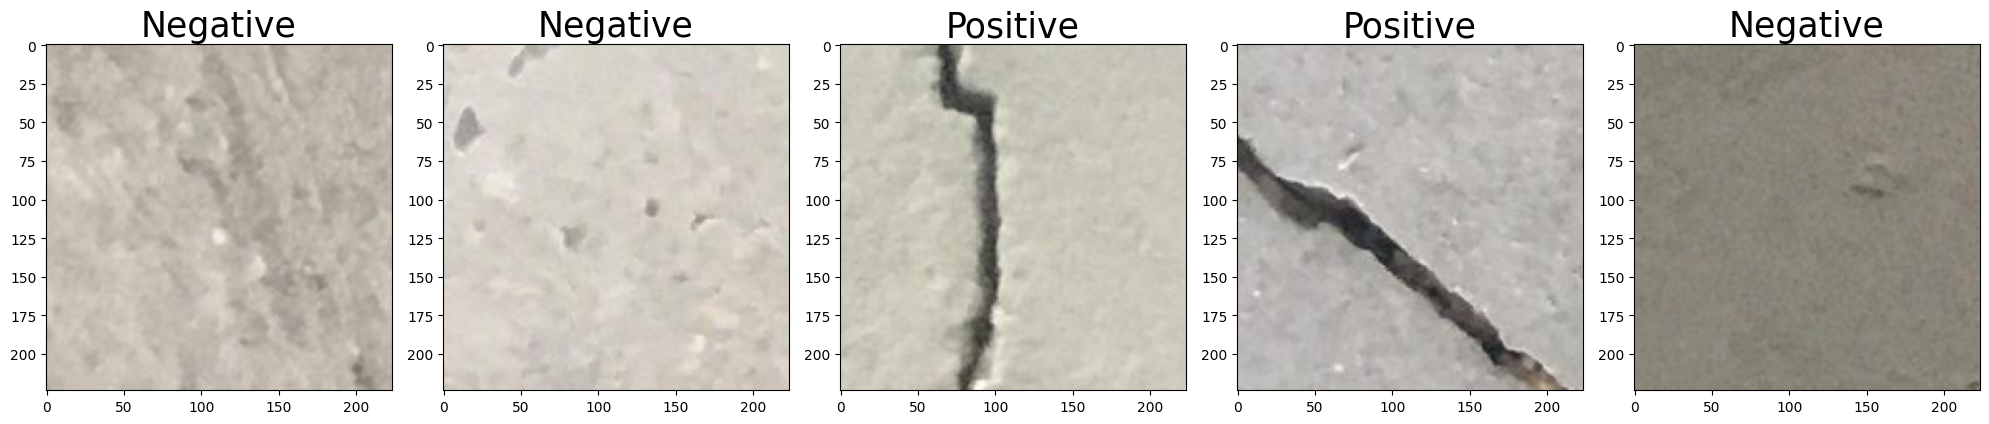

In [54]:
def reverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) 
    return tensor

fig, axes = plt.subplots(1, 5, figsize=(5 * 4, 4))
for idx, ax in zip(predictions, axes):
    transformed_image = reverse_normalize(dataset_val[idx][0].clone(), mean=mean, std=std)
    np_image = transformed_image.permute(1, 2, 0).numpy()
    image = np.clip(np_image, 0, 1)
    ax.imshow(image, cmap='gray')
    ax.set_title(predictions[idx],fontsize=25)
plt.tight_layout()
plt.show()

The Model trained with 40,000 images has an accuracy of 99%